# Project 2: inverse kinematics and resolved rate control

In this project, we will implement an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.

As a reminder, the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [1]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [2]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project2'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project2/')
    os.chdir('/content/ROB6003/Project2/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [1]:
import numpy as np
from scipy.linalg import expm, logm
import robot_visualizer
import time

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7000/static/


# Displaying an arbitrary configuration

As in the previous project, you can use the following function to display arbitrary configurations of the robot

In [2]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.56970875 0.47704327 0.82832228 0.10259803 0.52001258 0.13488547
 0.50448208]


In [3]:
def vec_to_skew(vector):               # Function to return a skew symmatric matrix by inputting a 3 by 1 matrix.
    if isinstance(vector, np.ndarray):
        return np.array([[0, -vector.item(2), vector.item(1)],
                         [vector.item(2), 0, -vector.item(0)],
                         [-vector.item(1), vector.item(0), 0]])
    else:
        return np.array([[0, -vector[2], vector[1]], 
                         [vector[2], 0, -vector[0]], 
                         [-vector[1], vector[0], 0]])

def twist_to_skew(V):  #Function to return a 4 by 4 Twist matrix by inputting a 6 by 1 matrix which contains first 3 elments angular and last 3 elements linear velocities.
    n = np.zeros((3,1))
    n = np.array([[V.item(0)],[V.item(1)],[V.item(2)]])
    Vans = np.zeros((4,4))
    Vans[0:3,0:3]=vec_to_skew(n)
    Vans[0:3,3:4]=np.array([[V.item(3)],[V.item(4)],[V.item(5)]])
    return Vans

def exp_twist_bracket(V): #Function to make a 4 by 4 twist matrix into a transformation matrix by taking its exponent.
   Vts = twist_to_skew(V)
   Ans = expm(Vts)
   return Ans

def inverseT(T): # Function to take an invere of a matrix.
    InvT = np.linalg.inv(T)
    return InvT

def getAdjoint(T):  #Function to get a 6 by 6 adjoint of a transformation matrix.
    P = np.array([[T.item(0,3)],[T.item(1,3)],[T.item(2,3)]])
    SkewP = vec_to_skew(P)
    SkewPR = np.matmul(SkewP,T[0:3,0:3])
    AdjT = np.zeros((6,6))
    AdjT[0:3,0:3] = T[0:3,0:3]
    AdjT[3:6,0:3] = SkewPR
    AdjT[0:3,3:6] = np.zeros((3,3))
    AdjT[3:6,3:6] = T[0:3,0:3]
    return AdjT

def forward_kinematics(theta):   #To get the Forward Kinematics or Transformation Matrix between end-effector frame and zero frame.
  
    s1 = np.zeros((6,1))
    w1 = np.array([[0],[0],[1]])
    p1 = np.array([[0],[0],[0.1575]])
    v1 = np.matmul(-vec_to_skew(w1),p1)
    s1[0:3,0:1] = w1
    s1[3:6,0:1] = v1

    s2 = np.zeros((6,1))
    p2 = ([[0],[0],[0.1575+0.2025]])
    w2 = np.array([[0],[1],[0]])
    v2 = np.matmul(-vec_to_skew(w2),p2)
    s2[0:3,0:1] = w2
    s2[3:6,0:1] = v2

    s3 = np.zeros((6,1))
    p3 = ([[0],[0],[0.1575+0.2025+0.2045]])
    w3 = np.array([[0],[0],[1]])
    v3 = np.matmul(-vec_to_skew(w3),p3)
    s3[0:3,0:1] = w3
    s3[3:6,0:1] = v3

    s4 = np.zeros((6,1))
    p4 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155]])
    w4 = np.array([[0],[-1],[0]])
    v4 = np.matmul(-vec_to_skew(w4),p4)
    s4[0:3,0:1] = w4
    s4[3:6,0:1] = v4

    s5 = np.zeros((6,1))
    p5 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845]])
    w5 = np.array([[0],[0],[1]])
    v5 = np.matmul(-vec_to_skew(w5),p5)
    s5[0:3,0:1] = w5
    s5[3:6,0:1] = v5

    s6 = np.zeros((6,1))
    p6 = ([[0],[-0.0607],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155]])
    w6 = np.array([[0],[1],[0]])
    v6 = np.matmul(-vec_to_skew(w6),p6)
    s6[0:3,0:1] = w6
    s6[3:6,0:1] = v6   

    s7 = np.zeros((6,1))
    p7 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155+0.0810]])
    w7 = np.array([[0],[0],[1]])
    v7 = np.matmul(-vec_to_skew(w3),p3)
    s7[0:3,0:1] = w7
    s7[3:6,0:1] = v7 

    M = np.array([[1,0,0,0],[0,1,0,0],[0,0,1, 0.1575+0.2025+0.2045+0.2155+0.1845+0.2155+0.0810+0.0400],[0,0,0,1]])

    S1 = exp_twist_bracket(s1*theta.item(0))
    S2 = exp_twist_bracket(s2*theta.item(1))
    S3 = exp_twist_bracket(s3*theta.item(2))
    S4 = exp_twist_bracket(s4*theta.item(3))
    S5 = exp_twist_bracket(s5*theta.item(4))
    S6 = exp_twist_bracket(s6*theta.item(5))
    S7 = exp_twist_bracket(s7*theta.item(6))

    T01 = np.matmul(S1,S2)
    T01 = np.matmul(T01,S3)
    T01 = np.matmul(T01,S4)
    T01 = np.matmul(T01,S5)
    T01 = np.matmul(T01,S6)
    T01 = np.matmul(T01,S7)
    T01 = np.matmul(T01,M)
    return T01  

def get_space_jacobian(theta):  #To get the Sapce Jacobian with respect to spatial frame.
    s1 = np.zeros((6,1))
    w1 = np.array([[0],[0],[1]])
    p1 = np.array([[0],[0],[0.1575]])
    v1 = np.matmul(-vec_to_skew(w1),p1)
    s1[0:3,0:1] = w1
    s1[3:6,0:1] = v1

    s2 = np.zeros((6,1))
    p2 = ([[0],[0],[0.1575+0.2025]])
    w2 = np.array([[0],[1],[0]])
    v2 = np.matmul(-vec_to_skew(w2),p2)
    s2[0:3,0:1] = w2
    s2[3:6,0:1] = v2

    s3 = np.zeros((6,1))
    p3 = ([[0],[0],[0.1575+0.2025+0.2045]])
    w3 = np.array([[0],[0],[1]])
    v3 = np.matmul(-vec_to_skew(w3),p3)
    s3[0:3,0:1] = w3
    s3[3:6,0:1] = v3

    s4 = np.zeros((6,1))
    p4 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155]])
    w4 = np.array([[0],[-1],[0]])
    v4 = np.matmul(-vec_to_skew(w4),p4)
    s4[0:3,0:1] = w4
    s4[3:6,0:1] = v4

    s5 = np.zeros((6,1))
    p5 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845]])
    w5 = np.array([[0],[0],[1]])
    v5 = np.matmul(-vec_to_skew(w5),p5)
    s5[0:3,0:1] = w5
    s5[3:6,0:1] = v5

    s6 = np.zeros((6,1))
    p6 = ([[0],[-0.0607],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155]])
    w6 = np.array([[0],[1],[0]])
    v6 = np.matmul(-vec_to_skew(w6),p6)
    s6[0:3,0:1] = w6
    s6[3:6,0:1] = v6   

    s7 = np.zeros((6,1))
    p7 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155+0.0810]])
    w7 = np.array([[0],[0],[1]])
    v7 = np.matmul(-vec_to_skew(w3),p3)
    s7[0:3,0:1] = w7
    s7[3:6,0:1] = v7

    S1 = exp_twist_bracket(s1*theta.item(0))
    S2 = exp_twist_bracket(s2*theta.item(1))
    S3 = exp_twist_bracket(s3*theta.item(2))
    S4 = exp_twist_bracket(s4*theta.item(3))
    S5 = exp_twist_bracket(s5*theta.item(4))
    S6 = exp_twist_bracket(s6*theta.item(5))

    Js1 = s1
    Js2 = np.matmul(getAdjoint(S1),s2)
    Js3 = np.matmul(getAdjoint(np.matmul(S1,S2)),s3)
    Js4 = np.matmul(getAdjoint(np.matmul(np.matmul(S1,S2),S3)),s4)
    Js5 = np.matmul(getAdjoint(np.matmul(np.matmul(np.matmul(S1,S2),S3),S4)),s5)
    Js6 = np.matmul(getAdjoint(np.matmul(np.matmul(np.matmul(np.matmul(S1,S2),S3),S4),S5)),s6)
    Js7 = np.matmul(getAdjoint(np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(S1,S2),S3),S4),S5),S6)),s7)

    Js = np.zeros((6,7))
    
    Js[0:6,0:1]=Js1
    Js[0:6,1:2]=Js2
    Js[0:6,2:3]=Js3
    Js[0:6,3:4]=Js4
    Js[0:6,4:5]=Js5
    Js[0:6,5:6]=Js6
    Js[0:6,6:7]=Js7

    return Js

## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [53]:
def compute_IK_position(V): #function to calculate the joint angles for the particular position using Numerical Inverse Kinematics Algoritham
    minimum_difference = 0.001 #The difference between modulus of position of calculated Inverse Kinematics and the modulus of given postion should not be greater than 0.001
    theta = np.array([[0],[0],[0],[0],[0],[0],[0]]) #Initial joint angles of the arm to perform the algorithm, The reason of choosing this becaus this position is not so far from every point.
    count = 0 #used to count the number of cycles that this algorithm performed.
    alpha = 0.1 #It is a small constant
    Tbe = np.zeros((4,4)) #A 4 by 4 Zero matrix.
    Tbe[3:4,0::] = [0,0,0,1] # Last row of Tbe is replaced by this row.
    Tbe[0:3,0:3] = np.eye(3) # Identity matrix to get a Jacobian having orientation of end-effector frame as same as the orientation of space frame.

    while True:
        Fk = forward_kinematics(theta) 
        Jacobians = get_space_jacobian(theta)
        Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4] #replacing the last column of the Tbe with the forward_kinematics between spatial and end-effector frame. The reason of doing so is because we want the spatial jacobian which will be oriented like spatial from but the origin is at the end-effector frame.
        Tbe = inverseT(Tbe)
        Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians) # Calculating Spatial Jacobian.
        Jp = np.linalg.pinv(Jacobianbe[3::,:]) #We need last three rows of this Jacobian for the further calculations.
        difference = np.matmul(Jp,(V - Fk[0:3,3:4])) #Now we are calculating the difference in joint angles.
        diff = np.sqrt(np.sum(np.square(V - forward_kinematics(theta)[0:3,3:4]))) #Difference between given position and the position calculated by Inverse Kinematics.
        theta_sol = theta
        # robot_visualizer.display_robot(theta) # To visualize the robot   
        if count == 0:
            diffp = diff
        if diff < diffp:
            diffp = diff
        if diff < minimum_difference or count == 100: #When the difference is less than 0.001 or if it's the 100th iteration the functionn will stop and return current joint angles calculated.
            print(count)
            print(diff)
            if count == 100:
                print("Closest we can reach = ", diffp)
            return theta_sol
            break
        
        theta = theta + alpha*difference
        count = count + 1

In [66]:
def compute_IK_position_nullspace(V): #function to calculate the joint angles for the particular position using Numerical Inverse Kinematics Algoritham with null space criteria giving it a situation in which the joint angles should remain near to the [[1],[1],[-1],[-1],[1],[1],[1]]
    minimum_difference = 0.001 #The difference between modulus of position of calculated Inverse Kinematica and the modulus of given postion should not be greater than 0.001
    theta = np.array([[1],[1],[-1],[-1],[1],[1],[1]]) #Initial joint angles of the arm to perform the algorithm, The reason of choosing this because this position is not so far from every point.
    count = 0 #used to count the number of cycles that this algorithm performed.
    alpha = 0.1 #It is a small constant
    Tbe = np.zeros((4,4)) #A 4 by 4 Zero matrix.
    Tbe[3:4,0::] = [0,0,0,1] # Last row of Tbe is replaced by this row.
    Tbe[0:3,0:3] = np.eye(3) # Identity matrix to get a Jacobian having orientation of end-effector frame as same as the orientation of space frame.

    while True:
        Fk = forward_kinematics(theta)
        Jacobians = get_space_jacobian(theta)
        Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4] #replacing the last column of the Tbe with the forward_kinematics between spatial and end-effector frame. The reason of doing so is because we want the spatial jacobian which will be oriented like spatial from but the origin is at the end-effector frame.
        Tbe = inverseT(Tbe)
        Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians) # Calculating Spatial Jacobian.
        Jp = np.linalg.pinv(Jacobianbe[3::,:]) #We need last three rows of this Jacobian for the further calculations.
        difference = np.matmul(Jp,(V - Fk[0:3,3:4])) #Now we are calculating the difference in joint angles.
        diff = np.sqrt(np.sum(np.square(V - forward_kinematics(theta)[0:3,3:4]))) #Difference between given position and the position calculated by Inverse Kinematics.
        theta_sol = theta
        robot_visualizer.display_robot(theta)
        if count == 0:
            diffp = diff
        if diff < diffp:
            diffp = diff
        if diff < minimum_difference or count == 200: #When the difference is less than 0.001 or if it's the 200th iteration the functionn will stop and return current joint angles calculated.
            print(count)
            print(diff)
            if count == 200:
                print("Closest we can reach = ", diffp)
            return theta_sol
            break
        
        theta = theta + alpha*difference + np.matmul((np.eye(7)-np.matmul(Jp,Jacobianbe[3::,:])),(np.array([[1],[1],[-1],[-1],[1],[1],[1]])-theta)) #We are applying a null space condition so the robot's joint angle should be nearby [[1],[1],[-1],[-1],[1],[1],[1]]
        count = count + 1

In [54]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
joint_angles = np.zeros((7,desired_endeff.shape[1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    joint_angles[0:7,i:i+1] = compute_IK_position(desired_endeff[:,i:i+1])
    time.sleep(1.)

100
0.43960598470092094
Closest we can reach =  0.28279354379252664
72
0.000931350263917777
58
0.0009033575917110412
70
0.0009689375960151462
61
0.0009532734790619814
100
0.08946037829940828
Closest we can reach =  0.07151957994029344
100
1.088412001496161
Closest we can reach =  0.3612660245959807
100
0.11537512028451459
Closest we can reach =  0.041591970176617636
64
0.0009420812036550482
69
0.0009556040166333692


In [67]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
joint_angles = np.zeros((7,desired_endeff.shape[1]))    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    joint_angles[0:7,i:i+1] = compute_IK_position_nullspace(desired_endeff[:,i:i+1])
    robot_visualizer.display_robot(joint_angles[0:7,i:i+1])
    
    
    time.sleep(1.)

200
0.2847938677287624
Closest we can reach =  0.2847938677287624
59
0.0009760344905397457
66
0.000913959833876007
68
0.0009085407138286112
65
0.0009903585587099184
200
0.07081679511269585
Closest we can reach =  0.06851381829845646
200
1.4478674287081459
Closest we can reach =  0.35928030490928337
200
0.12358623108161997
Closest we can reach =  0.04425545590387763
64
0.000981658073512287
62
0.0009511523527769938


## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

In [30]:
T = 10.
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]]) #goal point 1
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]]) #goal point 2
end_effector_start = np.array([[0],[0],[0],[0],[0],[0],[0]])
goal1_position = compute_IK_position_nullspace(end_effector_goal1) #inverse Kinematics for goa11
goal2_position = compute_IK_position_nullspace(end_effector_goal2) #inverse Kinematics for goal2


def get_point_to_point_motion(T,theta_init,theta_goal): #get_point_to_point_motion function which accepts total time duration, initial position and desired final position as input and returns a list of desired position and velocity. If the input is in Joint angles then it will return desire joint positions and velocities and if input is in form of linear position then it will return desired liear position and liear velocities.
    T = T/2
    dt = 0.001
    t = 0
    pos = []
    vel = []

    for i in range(int(T/dt)):

        posi = theta_init + (((10/(T**3))*(t**3)) - ((15*(t**4))/(T**4)) + (((6*(t**5)))/(T**5)))*(theta_goal-theta_init)
        veli = ((3*10/(T**3))*t**2 - (4*15*(t**3)/(T**4)) + (30/T**5)*(t**4))*(theta_goal-theta_init)
        pos.append(posi)
        vel.append(veli)
        # robot_visualizer.display_robot(posi)
        t = t+dt        
        
    return pos, vel


57
0.0009270222736881218
62
0.0009269004162330121


In [31]:
T = 10.
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])
dt = 0.001

# First of all, according to the question 2 we will perform Inverse Kinematics on both points that are
# denoted by end_effector_goal1 and end_effector_goal2.
# we will be using compute_IK_position_nullspace() function to do inverse kinematics.
end_effector_start = np.array([[0],[0],[0],[0],[0],[0],[0]])
goal1_position = compute_IK_position_nullspace(end_effector_goal1)
goal2_position = compute_IK_position_nullspace(end_effector_goal2)

a,b = get_point_to_point_motion(T,end_effector_start,goal1_position) #computing desired joint angles and velocites to reach to goal 1.
c,d = get_point_to_point_motion(T,goal1_position,goal2_position) #computing desired joint angles and velocities to go to goal1 to goal2.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities): 
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """

    if t < 5:
        desired_joint_positions = a[int(t/dt)] #extracting desired joint positions from the list
        desired_joint_velocities = b[int(t/dt)] #extracting desired joint velocities from the list

    elif t >= 5:
        desired_joint_positions = c[int((t-5)/dt)] #extracting desired joint positions from the lis
        desired_joint_velocities = d[int((t-5)/dt)] #extracting desired joint velocities from the list

    else:
        print("Done")
    # we compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])


    
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

57
0.0009270222736881218
62
0.0009269004162330121


Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

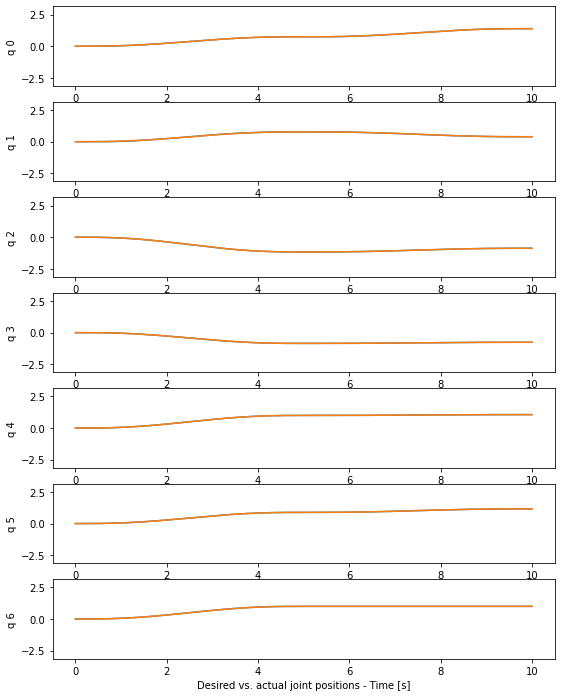

In [36]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

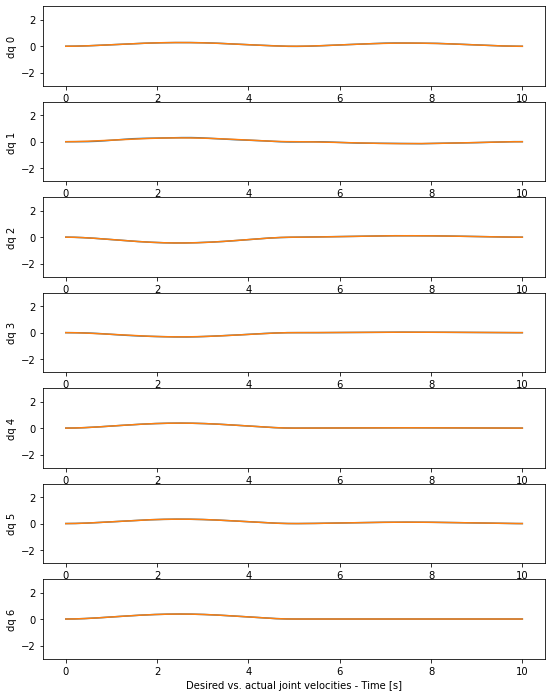

In [37]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

In [88]:
# Code to plot the X, Y and Z of positon coordinate with respect to time

xyz = np.zeros((3,len(save_joint_positions[0])))

for i in range(len(save_joint_positions[0])):
    xyz[0:3,i:i+1] = forward_kinematics(save_joint_positions[:,i:i+1])[0:3,3:4]


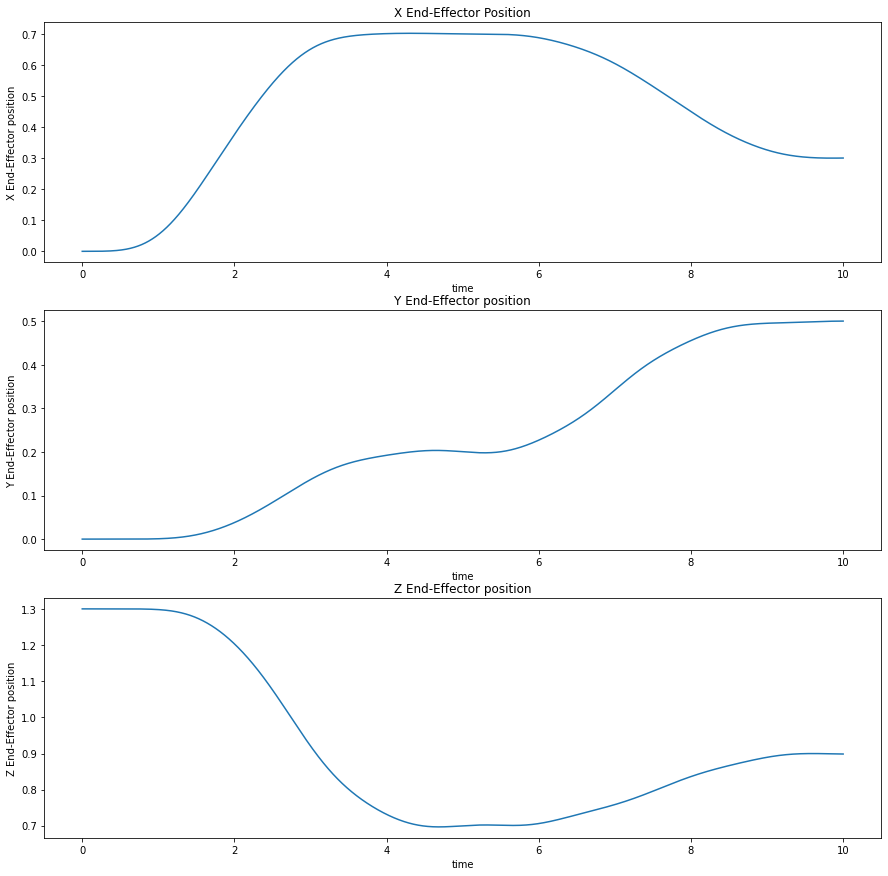

In [ ]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyz[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector position')
plt.title('X End-Effector Position')

plt.subplot(3,1,2)
plt.plot(save_t,xyz[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector position')
plt.title('Y End-Effector position')

plt.subplot(3,1,3)
plt.plot(save_t,xyz[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector position')
plt.title('Z End-Effector position')
plt.show()

In [91]:
# Code to plot the X, Y and Z of End-Effector Velocity coordinate with respect to time
#Spatial Jacobian
def jacobian_spatial(theta):
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    # Jplus = np.matmul(np.transpose(Jacobianbe[3::,:]),np.linalg.inv(np.matmul(Jacobianbe[3::,:],np.transpose(Jacobianbe[3::,:])) + e*np.eye(3)))
    return Jacobianbe[3::,:]  

xyzdot = np.zeros((3,len(save_joint_velocities[0])))

for i in range(len(save_joint_velocities[0])):
    xyzdot[0:3,i:i+1] = np.matmul(jacobian_spatial(save_joint_positions[:,i:i+1]),save_joint_velocities[:,i:i+1])

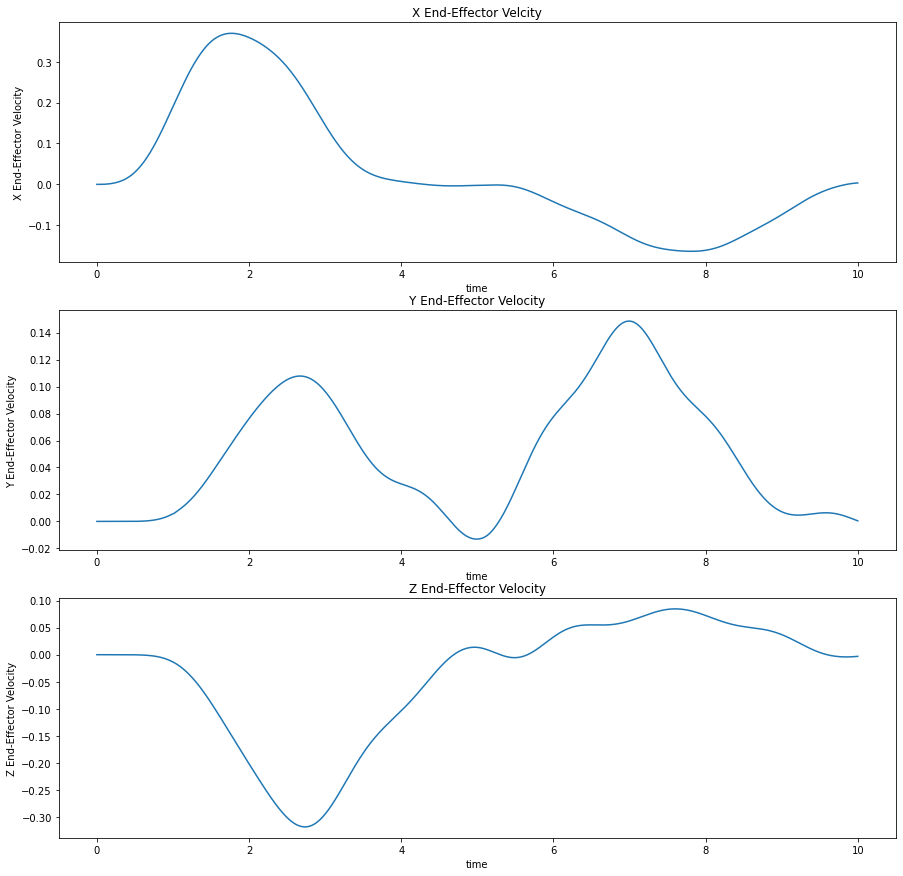

In [93]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyzdot[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector Velocity')
plt.title('X End-Effector Velcity')

plt.subplot(3,1,2)
plt.plot(save_t,xyzdot[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector Velocity')
plt.title('Y End-Effector Velocity')

plt.subplot(3,1,3)
plt.plot(save_t,xyzdot[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector Velocity')
plt.title('Z End-Effector Velocity')
plt.show()

## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [94]:
def jplus_function(theta):
    # minimum_difference = 0.001
    # # theta = np.array([[0],[0],[0],[0],[0],[0],[0]]) 
    # count = 0
    # alpha = 0.1
    e = 10e-4
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    # Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    Jplus = np.matmul(np.transpose(Jacobianbe[3::,:]),np.linalg.inv(np.matmul(Jacobianbe[3::,:],np.transpose(Jacobianbe[3::,:])) + e*np.eye(3)))
    return Jplus    

            
start_point = forward_kinematics(np.array([[0],[0],[0],[0],[0],[0],[0]]))[0:3,3:4]
# print(start_point)
a,b = get_point_to_point_motion(T,start_point,end_effector_goal1)
c,d = get_point_to_point_motion(T,end_effector_goal1,end_effector_goal2)



In [95]:
T = 10.

start_point = forward_kinematics(np.array([[0],[0],[0],[0],[0],[0],[0]]))[0:3,3:4]
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    global pp, pv
    P = 100
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    # desired_joint_positions = np.zeros([7,1])
    # desired_joint_velocities = np.zeros([7,1])
    if t == 0:
        jp = jplus_function(np.array([[0],[0],[0],[0],[0],[0],[0]]))
        desired_joint_positions = np.array([[0],[0],[0],[0],[0],[0],[0]])
        desired_joint_velocities = np.matmul(jp,b[int(t/dt)]+(P*(-forward_kinematics(joint_positions)[0:3,3:4]+a[int(t/dt)])))
        pp = np.array([[0],[0],[0],[0],[0],[0],[0]])
        pv = np.matmul(jp,b[int(t/dt)])

    elif t < 5 and t > 0:
        desired_joint_positions = pp + dt*pv
        jp = jplus_function(joint_positions)
        desired_joint_velocities = np.matmul(jp,b[int(t/dt)]+(P*(-forward_kinematics(joint_positions)[0:3,3:4]+a[int(t/dt)])))
        # print(P*(-forward_kinematics(desired_joint_positions)[0:3,3:4]+a[int(t/dt)]))
        pp = desired_joint_positions
        pv = desired_joint_velocities

    elif t >= 5:
        desired_joint_positions = pp + dt*pv
        jp = jplus_function(joint_positions)
        desired_joint_velocities = np.matmul(jp,d[int((t-5)/dt)]+(P*(-forward_kinematics(joint_positions)[0:3,3:4]+c[int((t-5)/dt)])))
        pp = desired_joint_positions
        pv = desired_joint_velocities

    else:
        print("Done")
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

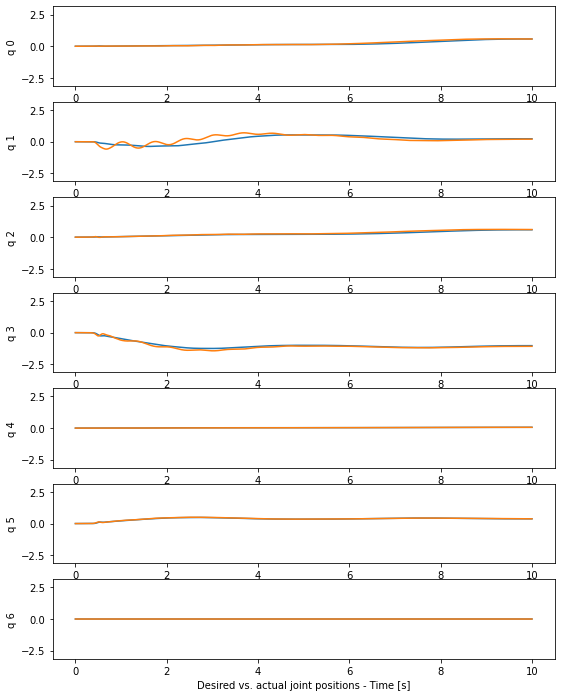

In [96]:
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

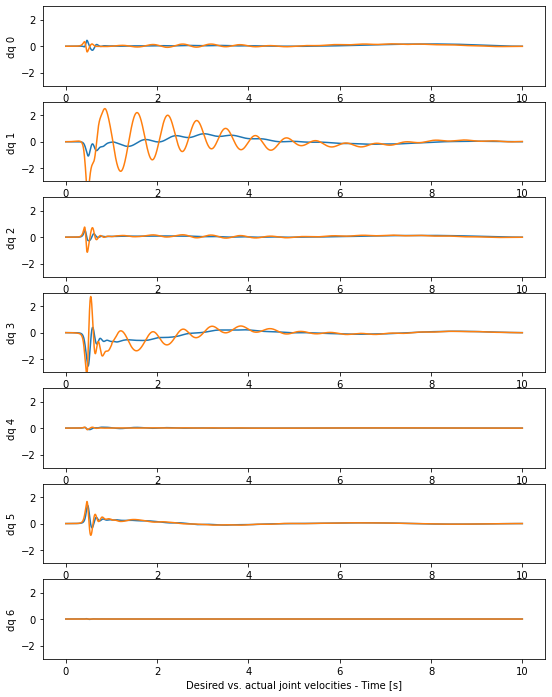

In [97]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

In [98]:
# Code to plot the X, Y and Z of positon coordinate with respect to time

xyz = np.zeros((3,len(save_joint_positions[0])))

for i in range(len(save_joint_positions[0])):
    xyz[0:3,i:i+1] = forward_kinematics(save_joint_positions[:,i:i+1])[0:3,3:4]

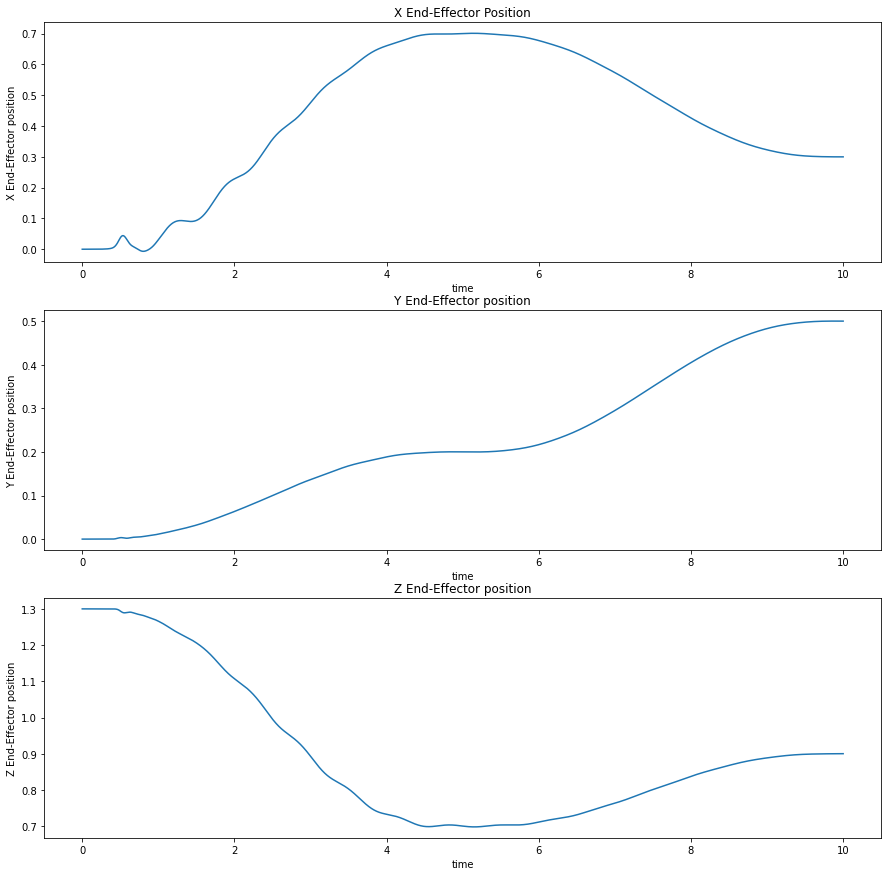

In [99]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyz[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector position')
plt.title('X End-Effector Position')

plt.subplot(3,1,2)
plt.plot(save_t,xyz[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector position')
plt.title('Y End-Effector position')

plt.subplot(3,1,3)
plt.plot(save_t,xyz[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector position')
plt.title('Z End-Effector position')
plt.show()

In [100]:
# Code to plot the X, Y and Z of End-Effector Velocity coordinate with respect to time
#Spatial Jacobian
def jacobian_spatial(theta):
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    # Jplus = np.matmul(np.transpose(Jacobianbe[3::,:]),np.linalg.inv(np.matmul(Jacobianbe[3::,:],np.transpose(Jacobianbe[3::,:])) + e*np.eye(3)))
    return Jacobianbe[3::,:]  

xyzdot = np.zeros((3,len(save_joint_velocities[0])))

for i in range(len(save_joint_velocities[0])):
    xyzdot[0:3,i:i+1] = np.matmul(jacobian_spatial(save_joint_positions[:,i:i+1]),save_joint_velocities[:,i:i+1])

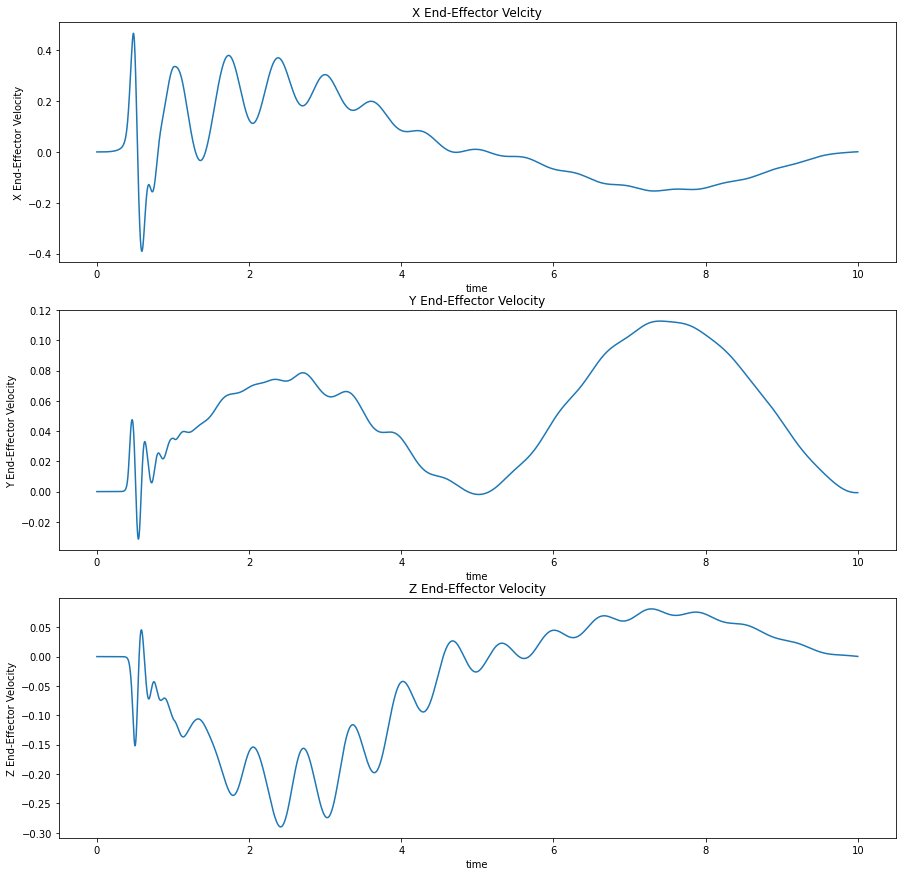

In [101]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyzdot[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector Velocity')
plt.title('X End-Effector Velcity')

plt.subplot(3,1,2)
plt.plot(save_t,xyzdot[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector Velocity')
plt.title('Y End-Effector Velocity')

plt.subplot(3,1,3)
plt.plot(save_t,xyzdot[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector Velocity')
plt.title('Z End-Effector Velocity')
plt.show()

In [ ]:
def jacobianbe(theta):
    # minimum_difference = 0.001
    # # theta = np.array([[0],[0],[0],[0],[0],[0],[0]]) 
    # count = 0
    # alpha = 0.1
    # e = 10e-4
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    # Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    # Jp = np.linalg.pinv(Jacobianbe[3::,:])
    return Jacobianbe[3::,:]

In [ ]:
# Now we are adding a nullspace position to this [[1],[1],[-1],[-1],[1],[1],[1]]
T = 10.

start_point = forward_kinematics(np.array([[0],[0],[0],[0],[0],[0],[0]]))[0:3,3:4]
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    global pp, pv
    P = 100
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    jp = jplus_function(joint_positions)
    Jacobianbe = jacobianbe(joint_positions)
    # desired_joint_positions = np.zeros([7,1])
    # desired_joint_velocities = np.zeros([7,1])
    if t == 0:
        jp = jplus_function(np.array([[0],[0],[0],[0],[0],[0],[0]]))
        desired_joint_positions = np.array([[0],[0],[0],[0],[0],[0],[0]])
        desired_joint_velocities = np.matmul(jp,b[int(t/dt)]+(P*(-forward_kinematics(joint_positions)[0:3,3:4]+a[int(t/dt)])))
        pp = np.array([[0],[0],[0],[0],[0],[0],[0]])
        pv = np.matmul(jp,b[int(t/dt)])

    elif t < 5 and t > 0:
        desired_joint_positions = pp + dt*pv + np.matmul((np.eye(7)-np.matmul(jp,Jacobianbe[3::,:])),(np.array([[1],[1],[-1],[-1],[1],[1],[1]])-theta))
        jp = jplus_function(joint_positions)
        desired_joint_velocities = np.matmul(jp,b[int(t/dt)]+(P*(-forward_kinematics(joint_positions)[0:3,3:4]+a[int(t/dt)])))
        # print(P*(-forward_kinematics(desired_joint_positions)[0:3,3:4]+a[int(t/dt)]))
        pp = desired_joint_positions
        pv = desired_joint_velocities

    elif t >= 5:
        desired_joint_positions = pp + dt*pv
        jp = jplus_function(joint_positions)
        desired_joint_velocities = np.matmul(jp,d[int((t-5)/dt)]+(P*(-forward_kinematics(joint_positions)[0:3,3:4]+c[int((t-5)/dt)])))
        pp = desired_joint_positions
        pv = desired_joint_velocities

    else:
        print("Done")
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

In [ ]:
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

In [ ]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

In [ ]:
# Code to plot the X, Y and Z of positon coordinate with respect to time

xyz = np.zeros((3,len(save_joint_positions[0])))

for i in range(len(save_joint_positions[0])):
    xyz[0:3,i:i+1] = forward_kinematics(save_joint_positions[:,i:i+1])[0:3,3:4]

In [ ]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyz[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector position')
plt.title('X End-Effector Position')

plt.subplot(3,1,2)
plt.plot(save_t,xyz[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector position')
plt.title('Y End-Effector position')

plt.subplot(3,1,3)
plt.plot(save_t,xyz[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector position')
plt.title('Z End-Effector position')
plt.show()

In [ ]:
# Code to plot the X, Y and Z of End-Effector Velocity coordinate with respect to time
#Spatial Jacobian
def jacobian_spatial(theta):
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    # Jplus = np.matmul(np.transpose(Jacobianbe[3::,:]),np.linalg.inv(np.matmul(Jacobianbe[3::,:],np.transpose(Jacobianbe[3::,:])) + e*np.eye(3)))
    return Jacobianbe[3::,:]  

xyzdot = np.zeros((3,len(save_joint_velocities[0])))

for i in range(len(save_joint_velocities[0])):
    xyzdot[0:3,i:i+1] = np.matmul(jacobian_spatial(save_joint_positions[:,i:i+1]),save_joint_velocities[:,i:i+1])

In [ ]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyzdot[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector Velocity')
plt.title('X End-Effector Velcity')

plt.subplot(3,1,2)
plt.plot(save_t,xyzdot[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector Velocity')
plt.title('Y End-Effector Velocity')

plt.subplot(3,1,3)
plt.plot(save_t,xyzdot[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector Velocity')
plt.title('Z End-Effector Velocity')
plt.show()

## Question 4: Impedance control and gravity compensation
As in Question 2 and 3, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

In the previous questions, a gravity compensation controller was running "in the background" in addition to the control law you were computing. In this question, we remove this and implement a complete impedance controller with gravity compensation.

You are given a function ``robot_visualizer.rnea(q,dq,ddq)`` which implements the Recursive Newton Euler Algorithm (RNEA). It takes as arguments a vector of positions, velocities and accelerations, and computes (and returns) the following $M(q) \cdot \ddot{q} + C(q,\dot{q}) + G(q)$

* Modify the ``robot_controller3`` function below to implement an impedance controller with gravity compensation (add a small amount of joint damping, using a joint-space D gain of 0.1). Use this controller to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions as in the previous questions.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare the controller when the small joint samping is on or off - can you explain the difference?
* Compare results with Question 2 and 3. Which controller would you rather choose and why?

In [102]:
def jacobianBe(theta):
    # minimum_difference = 0.001
    # # theta = np.array([[0],[0],[0],[0],[0],[0],[0]]) 
    # count = 0
    # alpha = 0.1
    # e = 10e-4
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    # Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    # Jp = np.linalg.pinv(Jacobianbe[3::,:])
    return Jacobianbe[3::,:]

In [103]:
T = 10.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code
P = 100
Dd = 4

def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    Gq = robot_visualizer.rnea(joint_positions,np.zeros((7,1)),np.zeros((7,1)))

    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    if t < 5:
        Torque = np.matmul(np.transpose(jacobianBe(joint_positions)),(P*(a[int(t/dt)]-forward_kinematics(joint_positions)[0:3,3:4])+Dd*(b[int(t/dt)]-np.matmul(jacobianBe(joint_positions),joint_velocities))))+Gq
    elif t >= 5:
        Torque = np.matmul(np.transpose(jacobianBe(joint_positions)),(P*(c[int((t-5)/dt)]-forward_kinematics(joint_positions)[0:3,3:4])+Dd*(d[int((t-5)/dt)]-np.matmul(jacobianBe(joint_positions),joint_velocities))))+Gq
    else:
        print("Done")

    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
    ##TODO - implement gravity compensation and impedance control
    
    desired_joint_torques = Torque-np.diag(D) @ joint_velocities
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.display_ball2([0.3, 0.5,0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp = False)

Text(0.5, 0, 'Joint positions - Time [s]')

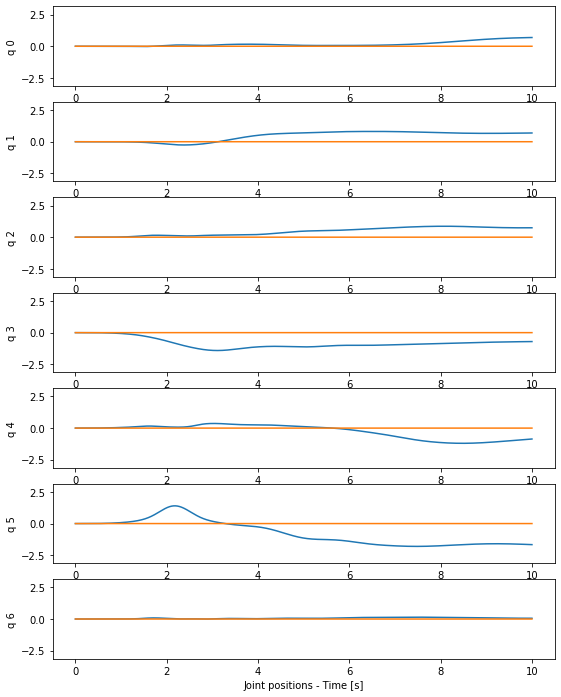

In [110]:
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Joint positions - Time [s]')

Text(0.5, 0, 'Joint velocities - Time [s]')

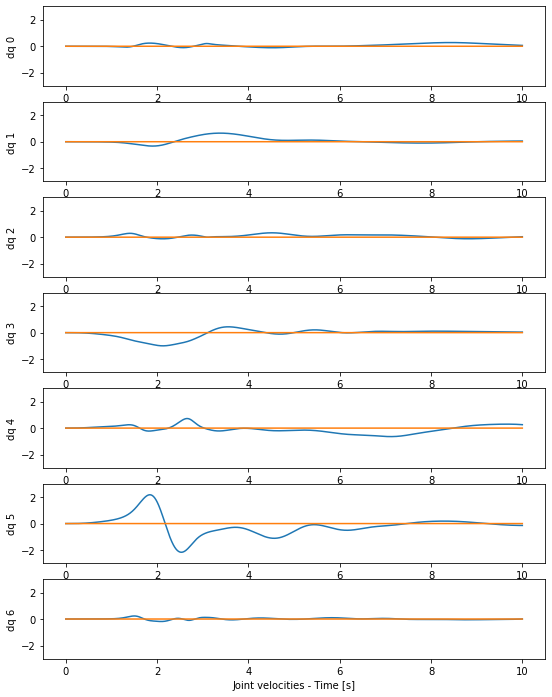

In [111]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Joint velocities - Time [s]')

In [106]:
# Code to plot the X, Y and Z of positon coordinate with respect to time

xyz = np.zeros((3,len(save_joint_positions[0])))

for i in range(len(save_joint_positions[0])):
    xyz[0:3,i:i+1] = forward_kinematics(save_joint_positions[:,i:i+1])[0:3,3:4]

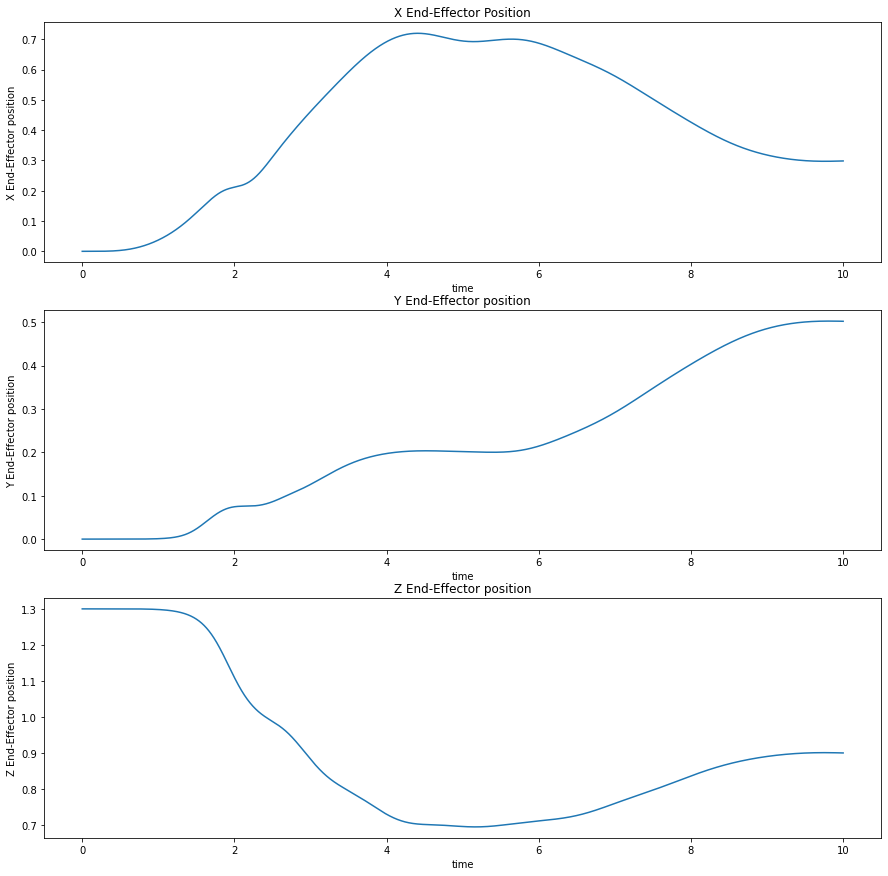

In [107]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyz[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector position')
plt.title('X End-Effector Position')

plt.subplot(3,1,2)
plt.plot(save_t,xyz[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector position')
plt.title('Y End-Effector position')

plt.subplot(3,1,3)
plt.plot(save_t,xyz[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector position')
plt.title('Z End-Effector position')
plt.show()

In [108]:
# Code to plot the X, Y and Z of End-Effector Velocity coordinate with respect to time
#Spatial Jacobian
def jacobian_spatial(theta):
    Tbe = np.zeros((4,4))
    Tbe[3:4,0::] = [0,0,0,1]
    Tbe[0:3,0:3] = np.eye(3)
    Fk = forward_kinematics(theta)
    Jacobians = get_space_jacobian(theta)
    Tbe[0:3,3:4] = forward_kinematics(theta)[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    # Jplus = np.matmul(np.transpose(Jacobianbe[3::,:]),np.linalg.inv(np.matmul(Jacobianbe[3::,:],np.transpose(Jacobianbe[3::,:])) + e*np.eye(3)))
    return Jacobianbe[3::,:]  

xyzdot = np.zeros((3,len(save_joint_velocities[0])))

for i in range(len(save_joint_velocities[0])):
    xyzdot[0:3,i:i+1] = np.matmul(jacobian_spatial(save_joint_positions[:,i:i+1]),save_joint_velocities[:,i:i+1])

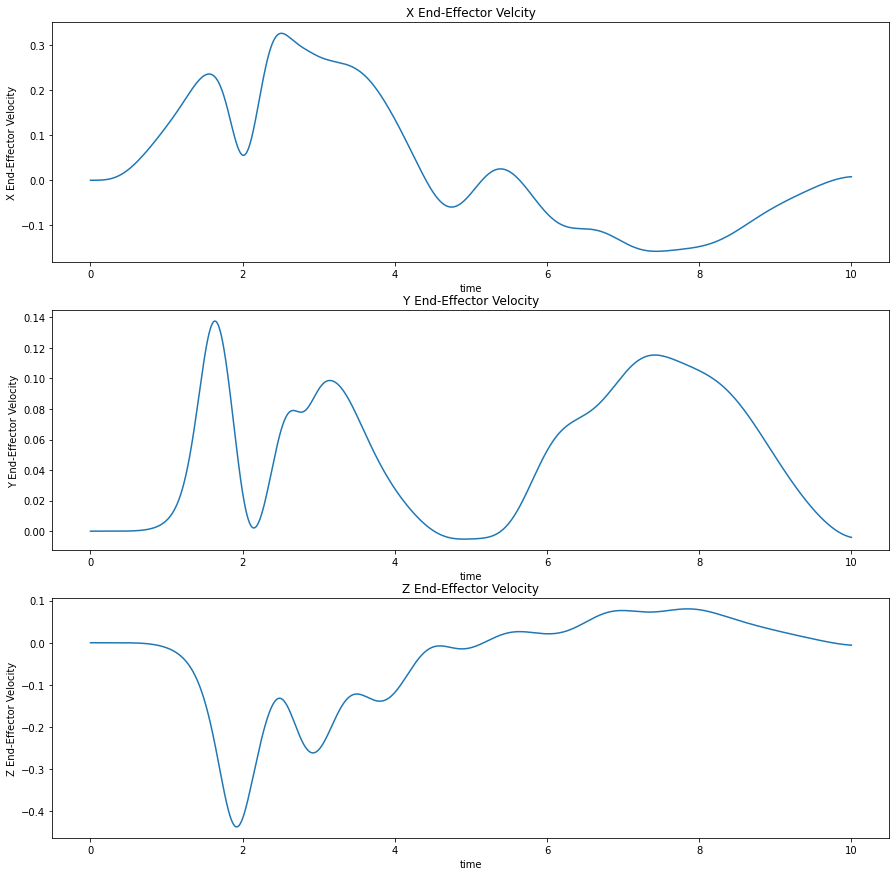

In [109]:
plt.figure(figsize=[15,15])
# %matplotlib widget
plt.subplot(3,1,1)
plt.plot(save_t,xyzdot[0,:])
plt.xlabel('time')
plt.ylabel('X End-Effector Velocity')
plt.title('X End-Effector Velcity')

plt.subplot(3,1,2)
plt.plot(save_t,xyzdot[1,:])
plt.xlabel('time')
plt.ylabel('Y End-Effector Velocity')
plt.title('Y End-Effector Velocity')

plt.subplot(3,1,3)
plt.plot(save_t,xyzdot[2,:])
plt.xlabel('time')
plt.ylabel('Z End-Effector Velocity')
plt.title('Z End-Effector Velocity')
plt.show()